In [1]:
# first install package
!pip install keras==2.14.0
!pip install tensorflow
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.14.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0


In [2]:
# Import the python library we need
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.layers import Dropout

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [50]:
data = 'stock.csv'
dataframe = pd.read_csv(data)
dataframe = dataframe.drop(dataframe.columns[0], axis=1)
traindata = dataframe
dataframe = dataframe.head(5760)
dataframe.head


<bound method NDFrame.head of        CSCO
0     48.10
1     48.10
2     48.20
3     48.20
4     48.20
...     ...
5755  48.73
5756  48.83
5757  48.83
5758  48.83
5759  48.83

[5760 rows x 1 columns]>

In [40]:
train_ratio = 0.8
training_set_size = int(dataframe.shape[0] * train_ratio)
train_data = dataframe[ :training_set_size]
test_data = dataframe[training_set_size :]


# Normalized processing
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_norm = scaler.fit_transform(train_data)
test_data_norm = scaler.fit_transform(test_data)

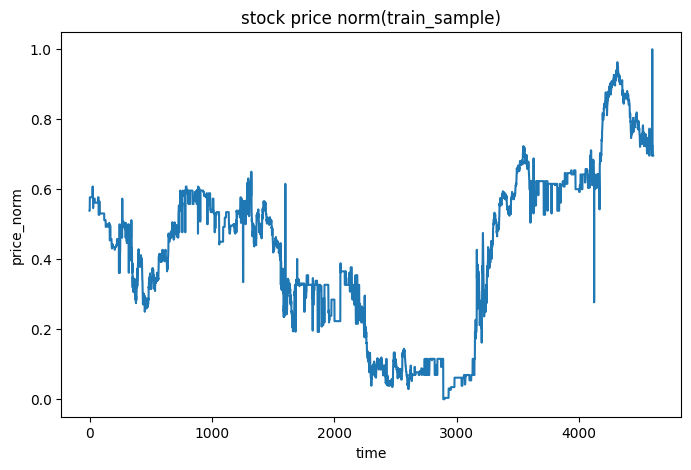

In [41]:
 #plot our graph of train_sample first
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8,5))
plt.plot(train_data_norm)
plt.title('stock price norm(train_sample)')
plt.xlabel('time')
plt.ylabel('price_norm')
plt.show()

In [42]:
def create_dataset(data,n_predictions,nth):
    train_X,train_y = [],[]
    for i in range(data.shape[0]-n_predictions-nth-1):
        a = data[i:(i+n_predictions)]
        train_X.append(a)
        b = data[i+n_predictions+nth]
        train_y.append(b)
    train_X = np.array(train_X,dtype='float64')
    train_y = np.array(train_y,dtype='float64')
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)

    return train_X, train_y

In [51]:
# the full period of data
p = 0.8
size = int(traindata.shape[0] * p)
full_train_data = dataframe[ :size]
full_test_data = dataframe[size :]


# Normalized processing
scaler = MinMaxScaler(feature_range=(0, 1))
full_train_data_norm = scaler.fit_transform(full_train_data)
full_test_data_norm = scaler.fit_transform(full_test_data)
time_step = 120
nth = 10
full_train_X,full_train_y = create_dataset(full_train_data_norm,time_step,nth)
full_test_X,full_test_y = create_dataset(full_test_data_norm,time_step,nth)


In [43]:
# generate train_X,train_y,test_X,test_y
# We need to decide the out time_step: means using previous time_step minutes to predict 1 future minite
time_step = 120
nth = 10
train_X,train_y = create_dataset(train_data_norm,time_step,nth)
test_X,test_y = create_dataset(test_data_norm,time_step,nth)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)



(4477, 120, 1)
(1021, 120, 1)
(4477, 1)
(1021, 1)


In [44]:
# Contruct our model
# 2 layer LSTM model
def LSTM_model(lstm_neurons=50,dropout=0.2,activation='relu',dense_units='20',optimizer='adam'):
  X = train_X
  y = train_y
  LSTM_model = Sequential()
  # Hidden layer 1: LSTM
  LSTM_model.add(LSTM(lstm_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  LSTM_model.add(Dropout(dropout))
  # Hidden layer 2: LSTM
  LSTM_model.add(LSTM(lstm_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more lstm layers here

  # Output layer: Dense
  LSTM_model.add(Dense(1))
  # Configure the model
  LSTM_model.compile(optimizer ,loss='mean_squared_error')
  return LSTM_model

In [45]:
# Define our alternative hyperparameters directionary
# The parameters in this table can be expanded
parameters_grid = { 'model__lstm_neurons': [50,60,70],
           'model__activation': ['relu', 'tanh', 'sigmoid'],
           'model__optimizer':['adam', 'rmsprop','sgd'],

}

In [46]:
 # Grid search
model = KerasRegressor(model=LSTM_model, epochs=10, batch_size=32, verbose=2)
grid = GridSearchCV(estimator=model, param_grid = parameters_grid, scoring='neg_mean_squared_error',cv=3, error_score='raise')

grid_result = grid.fit(train_X, train_y)
# Display the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Print the result
print("Best Parameters for our LSTM model is : ", grid_result.best_params_)

Epoch 1/10
94/94 - 13s - loss: 0.0296 - 13s/epoch - 137ms/step
Epoch 2/10
94/94 - 8s - loss: 0.0026 - 8s/epoch - 90ms/step
Epoch 3/10
94/94 - 9s - loss: 0.0024 - 9s/epoch - 98ms/step
Epoch 4/10
94/94 - 8s - loss: 0.0024 - 8s/epoch - 88ms/step
Epoch 5/10
94/94 - 9s - loss: 0.0024 - 9s/epoch - 93ms/step
Epoch 6/10
94/94 - 9s - loss: 0.0024 - 9s/epoch - 98ms/step
Epoch 7/10
94/94 - 8s - loss: 0.0024 - 8s/epoch - 82ms/step
Epoch 8/10
94/94 - 10s - loss: 0.0023 - 10s/epoch - 102ms/step
Epoch 9/10
94/94 - 9s - loss: 0.0023 - 9s/epoch - 97ms/step
Epoch 10/10
94/94 - 8s - loss: 0.0022 - 8s/epoch - 85ms/step
47/47 - 1s - 1s/epoch - 30ms/step
Epoch 1/10
94/94 - 12s - loss: 0.0297 - 12s/epoch - 124ms/step
Epoch 2/10
94/94 - 9s - loss: 0.0027 - 9s/epoch - 98ms/step
Epoch 3/10
94/94 - 8s - loss: 0.0026 - 8s/epoch - 83ms/step
Epoch 4/10
94/94 - 10s - loss: 0.0026 - 10s/epoch - 105ms/step
Epoch 5/10
94/94 - 9s - loss: 0.0025 - 9s/epoch - 97ms/step
Epoch 6/10
94/94 - 8s - loss: 0.0025 - 8s/epoch - 83m

In [52]:
# Train our LSTM model
def train_model(X,y,lstm_neurons,dropout,activation,optimizer='adam'):
  LSTM_model = Sequential()
  # Hidden layer 1: LSTM
  LSTM_model.add(LSTM(lstm_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  LSTM_model.add(Dropout(dropout))
  # Hidden layer 2: LSTM
  LSTM_model.add(LSTM(lstm_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more lstm layers here

  # Output layer: Dense
  LSTM_model.add(Dense(1))
  # Configure the model
  LSTM_model.compile(optimizer ,loss='mean_squared_error')
  return LSTM_model

our_model = train_model(X=full_train_X,y=full_train_y,lstm_neurons=60,dropout=0.2,activation='tanh',optimizer='adam')
history = our_model.fit(full_train_X, full_train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y),verbose=1)


Epoch 1/10
140/140 [==============================] - 24s 138ms/step - loss: 0.0072 - val_loss: 0.0090
Epoch 2/10
140/140 [==============================] - 17s 124ms/step - loss: 0.0023 - val_loss: 0.0094
Epoch 3/10
140/140 [==============================] - 18s 127ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 4/10
140/140 [==============================] - 18s 125ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 5/10
140/140 [==============================] - 20s 142ms/step - loss: 0.0022 - val_loss: 0.0086
Epoch 6/10
140/140 [==============================] - 19s 133ms/step - loss: 0.0021 - val_loss: 0.0089
Epoch 7/10
140/140 [==============================] - 20s 144ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 8/10
140/140 [==============================] - 17s 125ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 9/10
140/140 [==============================] - 19s 134ms/step - loss: 0.0022 - val_loss: 0.0086
Epoch 10/10
140/140 [==============================] - 17s 123ms/step - l

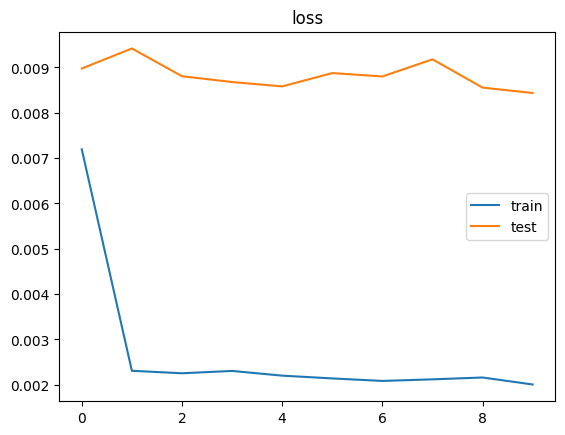

In [53]:
# plot history loss graph
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'],label='test')
plt.title('loss')
plt.legend()
plt.show()

In [55]:
y_hat_LSTM  =  our_model.predict(full_test_X)
print(y_hat_LSTM.shape)
original_y_hat = scaler.inverse_transform(y_hat_LSTM)
original_y_test = scaler.inverse_transform(full_test_y)

32/32 [==============================] - 2s 54ms/step
(1021, 1)


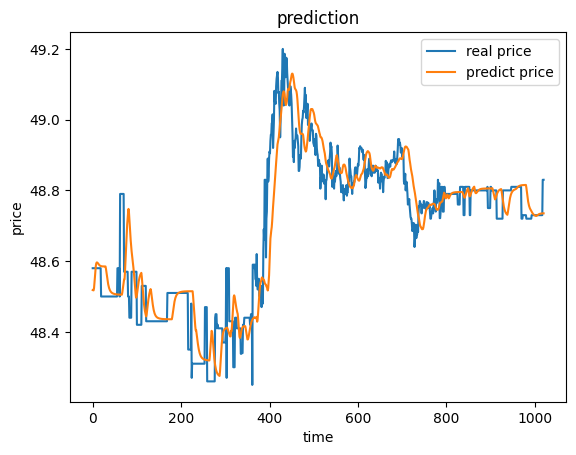

0.007614211917083506


In [56]:
plt.plot(original_y_test,label='real price')
plt.plot(original_y_hat,label='predict price')
plt.legend()
plt.title('prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.show()
# error measure
test_MSE = mean_squared_error(original_y_test, original_y_hat)
print(test_MSE)

In [57]:
#RNN part
# Contruct our model
# 2 layer RNN model
def RNN_model(Rnn_neurons=50,dropout=0.2,activation='relu',dense_units='20',optimizer='adam'):
  X = train_X
  y = train_y
  RNN_model = Sequential()
  # Hidden layer 1: RNN
  RNN_model.add(SimpleRNN(Rnn_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  RNN_model.add(Dropout(dropout))
  # Hidden layer 2: RNN
  RNN_model.add(SimpleRNN(Rnn_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more lstm layers here

  # Output layer: Dense
  RNN_model.add(Dense(1))
  # Configure the model
  RNN_model.compile(optimizer ,loss='mean_squared_error')
  return RNN_model

In [58]:
# Define our alternative hyperparameters directionary
# The parameters in this table can be expanded
parameters_grid_rnn = { 'model__Rnn_neurons': [50,60,70],
           'model__activation': ['relu', 'tanh', 'sigmoid'],
           'model__optimizer':['adam', 'rmsprop','sgd'],

}

In [59]:
 # Grid search
model = KerasRegressor(model=RNN_model, epochs=10, batch_size=32, verbose=2)
grid = GridSearchCV(estimator=model, param_grid = parameters_grid_rnn, scoring='neg_mean_squared_error',cv=3, error_score='raise')

grid_result = grid.fit(train_X, train_y)
# Display the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Print the result
print("Best Parameters for our RNN model is : ", grid_result.best_params_)

Epoch 1/10
94/94 - 7s - loss: 0.0207 - 7s/epoch - 75ms/step
Epoch 2/10
94/94 - 5s - loss: 0.0033 - 5s/epoch - 56ms/step
Epoch 3/10
94/94 - 4s - loss: 0.0028 - 4s/epoch - 45ms/step
Epoch 4/10
94/94 - 5s - loss: 0.0026 - 5s/epoch - 54ms/step
Epoch 5/10
94/94 - 5s - loss: 0.0024 - 5s/epoch - 51ms/step
Epoch 6/10
94/94 - 4s - loss: 0.0023 - 4s/epoch - 44ms/step
Epoch 7/10
94/94 - 5s - loss: 0.0022 - 5s/epoch - 57ms/step
Epoch 8/10
94/94 - 4s - loss: 0.0020 - 4s/epoch - 46ms/step
Epoch 9/10
94/94 - 4s - loss: 0.0021 - 4s/epoch - 44ms/step
Epoch 10/10
94/94 - 6s - loss: 0.0020 - 6s/epoch - 61ms/step
47/47 - 1s - 1s/epoch - 27ms/step
Epoch 1/10
94/94 - 6s - loss: 0.0159 - 6s/epoch - 64ms/step
Epoch 2/10
94/94 - 5s - loss: 0.0040 - 5s/epoch - 48ms/step
Epoch 3/10
94/94 - 5s - loss: 0.0031 - 5s/epoch - 56ms/step
Epoch 4/10
94/94 - 4s - loss: 0.0027 - 4s/epoch - 45ms/step
Epoch 5/10
94/94 - 5s - loss: 0.0025 - 5s/epoch - 56ms/step
Epoch 6/10
94/94 - 5s - loss: 0.0023 - 5s/epoch - 48ms/step
Epoch

In [62]:
# Train our LSTM model
def train_RNN_model(X,y,Rnn_neurons,dropout,activation,optimizer='adam'):
  RNN_model = Sequential()
  # Hidden layer 1: RNN
  RNN_model.add(SimpleRNN(Rnn_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  RNN_model.add(Dropout(dropout))
  # Hidden layer 2: RNN
  RNN_model.add(SimpleRNN(Rnn_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more RNN layers here

  # Output layer: Dense
  RNN_model.add(Dense(1))
  # Configure the model
  RNN_model.compile(optimizer ,loss='mean_squared_error')
  return RNN_model
our_RNN_model = train_RNN_model(X=full_train_X,y=full_train_y,Rnn_neurons=60,dropout=0.2,activation='tanh',optimizer='rmsprop')
history = our_model.fit(full_train_X, full_train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y),verbose=1)

Epoch 1/10
140/140 [==============================] - 18s 127ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 2/10
140/140 [==============================] - 19s 135ms/step - loss: 0.0020 - val_loss: 0.0083
Epoch 3/10
140/140 [==============================] - 19s 134ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 4/10
140/140 [==============================] - 19s 137ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 5/10
140/140 [==============================] - 20s 147ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 6/10
140/140 [==============================] - 20s 144ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 7/10
140/140 [==============================] - 17s 122ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 8/10
140/140 [==============================] - 18s 125ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 9/10
140/140 [==============================] - 20s 141ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 10/10
140/140 [==============================] - 18s 126ms/step - l

In [63]:
y_hat_RNN  =  our_RNN_model.predict(full_test_X)
print(y_hat_RNN.shape)
original_y_hat_RNN = scaler.inverse_transform(y_hat_RNN)
original_y_test_RNN = scaler.inverse_transform(full_test_y)

32/32 [==============================] - 1s 20ms/step
(1021, 1)


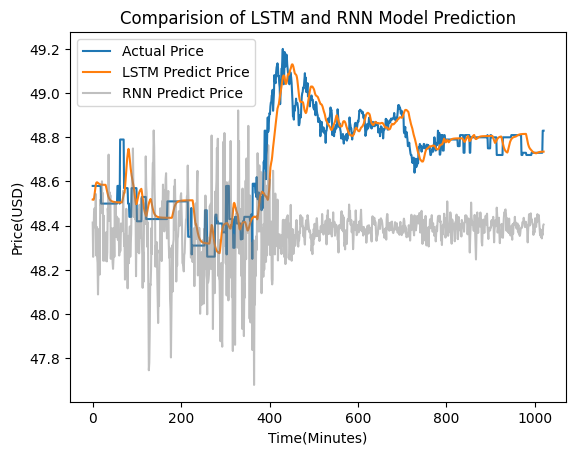

0.1569013770142888


In [69]:
plt.plot(original_y_test_RNN,label='Actual Price')
plt.plot(original_y_hat,label='LSTM Predict Price')
plt.plot(original_y_hat_RNN,label='RNN Predict Price',color='gray',alpha = 0.5)
plt.legend()
plt.title('Comparision of LSTM and RNN Model Prediction')
plt.xlabel('Time(Minutes)')
plt.ylabel('Price(USD)')
plt.show()
# error measure
test_MSE = mean_squared_error(original_y_test_RNN, original_y_hat_RNN)
print(test_MSE)